In [101]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

%load_ext autoreload
%autoreload 2

plt.style.use(["science"])
plt.rcParams["figure.figsize"] = (12, 7)


### 1. Ignoring refactory time

<Axes: >

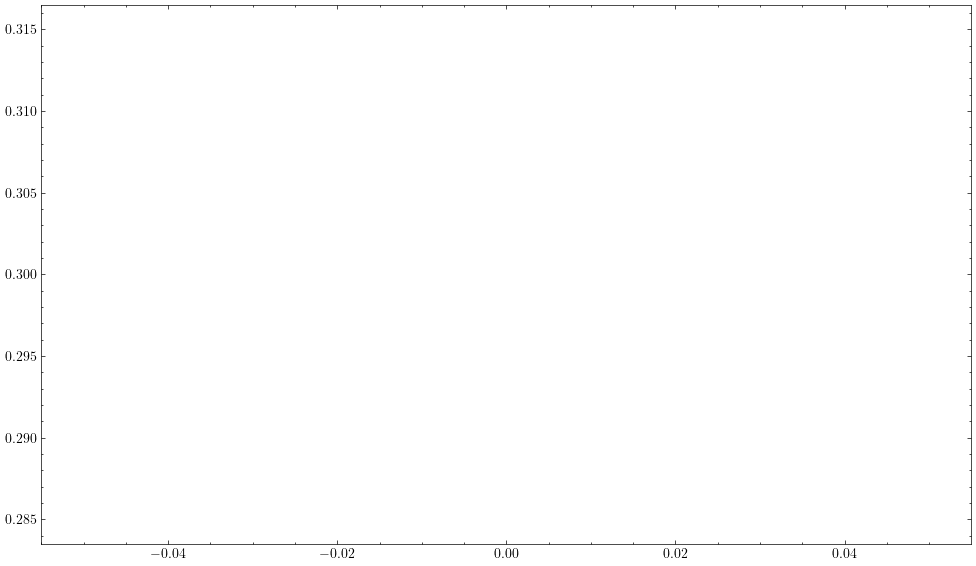

In [127]:
import numpy as np
import seaborn as sns
import scipy


def recursive_formula(S_n, P_e, locked_spikes=0):
    return S_n * P_e * (1 - S_n - locked_spikes)


S_0 = 0.3  # Spiked at t=0
P_e = 0.2

timesteps = np.arange(0, 200)
S_tabs = [S_0]
for t in timesteps[1:]:
    S_old = S_tabs[-1]
    S_new = recursive_formula(S_old, P_e)
    if S_new <= 1:
        break
    S_tabs.append(S_new)

sns.lineplot(x=timesteps[: len(S_tabs)], y=S_tabs)

In [128]:
MODULE_SIZE = 625


def compute_survivaltime(S_0, P_e):
    timesteps = np.arange(0, 200)
    S_tabs = [S_0]
    for t in timesteps[1:]:
        S_old = S_tabs[-1]
        S_new = recursive_formula(S_old, P_e)

        if S_new <= (1 / MODULE_SIZE):
            break
        S_tabs.append(S_new)

    return t


steps = 200
P_e = np.arange(0, 0.8, 0.8 / steps)
S_0 = np.arange(0, 0.8, 0.8 / steps)

X, Y = np.meshgrid(P_e, S_0)

Z = []
for i, x in enumerate(P_e):
    Z.append([])
    for j, y in enumerate(S_0):
        z = compute_survivaltime(x, y)
        Z[i].append(z)

Z = np.array(Z)

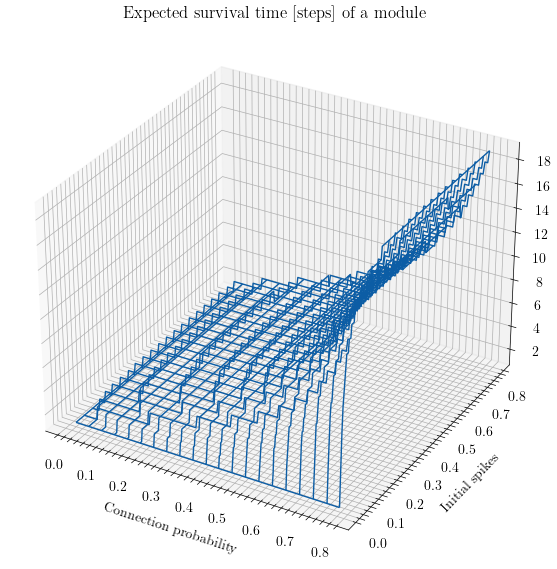

In [129]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Grab some test data.
# X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.set_xlabel("Connection probability")
ax.set_ylabel("Initial spikes")
ax.set_zlabel("Survival time")
ax.set_title("Expected survival time [steps] of a module")

plt.show()

### 2. Including refactory time

In [191]:
MODULE_SIZE = 625


def parse_refactoring(refactory_dict):
    parsed_dict = {k - 1: v for k, v in refactory_dict.items()}
    unlocked_spikes = parsed_dict.pop(0, 0)
    return parsed_dict, unlocked_spikes


def recursive_formula_with_refactory(S_old, P_e, refactory_dict, effective_refactory):
    refactory_dict, unlocked_spikes = parse_refactoring(refactory_dict)
    locked_spikes = sum(refactory_dict.values())
    S_new = recursive_formula(S_old + unlocked_spikes, P_e, locked_spikes)
    refactory_dict[effective_refactory] = S_old

    return S_new, refactory_dict


def compute_survivaltime_with_refactory(S_0, P_e, effective_refactory):
    timesteps = np.arange(0, 200)
    S_tabs = [S_0]
    refactory_dict = {}
    for t in timesteps[1:]:
        # print(refactory_dict)
        S_old = S_tabs[-1]
        S_new, refactory_dict = recursive_formula_with_refactory(
            S_old, P_e, refactory_dict, effective_refactory
        )

        if S_new <= (1 / MODULE_SIZE):
            break
        S_tabs.append(S_new)

    return t

In [192]:
tao_ref = 5  # ms
tao_syn = 1  # ms
effective_refactory = tao_ref / tao_syn


steps = 200
MAX_P_e = 0.8
MAX_S_0 = 1.0
P_e = np.arange(0, MAX_P_e + MAX_P_e / steps, MAX_P_e / steps)
S_0 = np.arange(0, MAX_S_0 + MAX_S_0 / steps, MAX_S_0 / steps)

X, Y = np.meshgrid(P_e, S_0)

Z = []
for i, x in enumerate(P_e):
    Z.append([])
    for j, y in enumerate(S_0):
        z = compute_survivaltime_with_refactory(
            S_0=y, P_e=x, effective_refactory=effective_refactory
        )
        Z[i].append(z)

Z = np.array(Z)

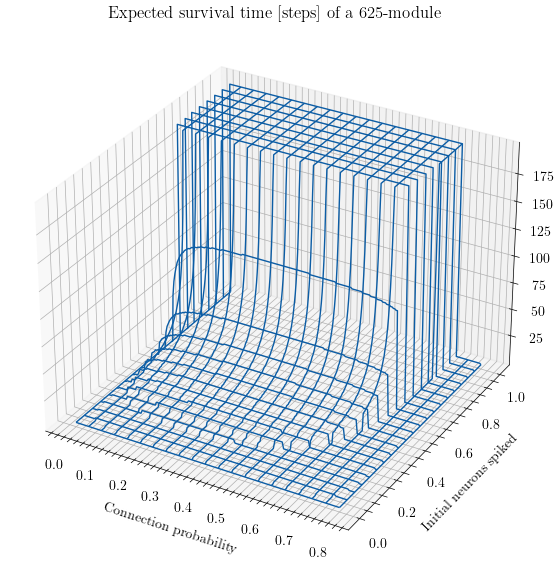

In [188]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.set_xlabel("Connection probability")
ax.set_ylabel("Initial neurons spiked")
ax.set_zlabel("Survival time")
ax.set_title(f"Expected survival time [steps] of a {MODULE_SIZE}-module")

plt.show()

### 3. Make it more concise

In [205]:
compute_survivaltime_with_refactory(
    S_0=0.8, P_e=0.2, effective_refactory=2
)

2

Data generated.


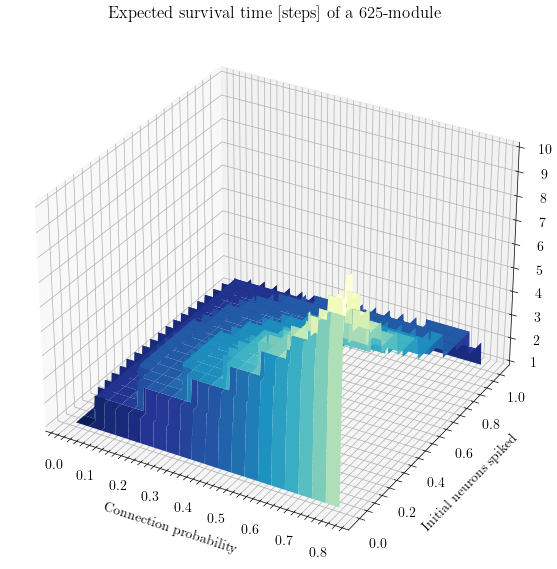

In [221]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


def generate_survival_time_data(MAX_P_e, MAX_S_0, steps, effective_refactory):
    P_e_tab = np.arange(0, MAX_P_e + MAX_P_e / steps, MAX_P_e / steps)
    S_0_tab = np.arange(0, MAX_S_0 + MAX_S_0 / steps, MAX_S_0 / steps)

    X, Y = np.meshgrid(P_e_tab, S_0_tab)

    Z = np.zeros((len(P_e_tab), len(S_0_tab)))
    for i, P_e in enumerate(P_e_tab):
        for j, S_0 in enumerate(S_0_tab):
            z = compute_survivaltime_with_refactory(
                S_0=S_0, P_e=P_e, effective_refactory=effective_refactory
            )
            Z[j][i] = z

    print("Data generated.")
    return X, Y, Z


def plot_survival_time(X, Y, Z):
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    # Plot a basic wireframe.
    ax.plot_surface(X, Y, Z, rstride=10, cstride=10, cmap=plt.cm.YlGnBu_r)
    ax.set_xlabel("Connection probability")
    ax.set_ylabel("Initial neurons spiked")
    ax.set_zlabel("Survival time")
    ax.set_title(f"Expected survival time [steps] of a {MODULE_SIZE}-module")

    plt.show()


tao_ref = 5  # ms
tao_syn = 2  # ms
effective_refactory = tao_ref / tao_syn

steps = 200
MAX_P_e = 0.8
MAX_S_0 = 1.0


X, Y, Z = generate_survival_time_data(MAX_P_e, MAX_S_0, steps, effective_refactory)
plot_survival_time(X, Y, Z)

/tmp/ipykernel_7502/3522172101.py:6: RuntimeWarning: divide by zero encountered in power
  y_data = [0.02 * x_data**-a for a in alpha]
/tmp/ipykernel_7502/3522172101.py:6: RuntimeWarning: divide by zero encountered in reciprocal
  y_data = [0.02 * x_data**-a for a in alpha]


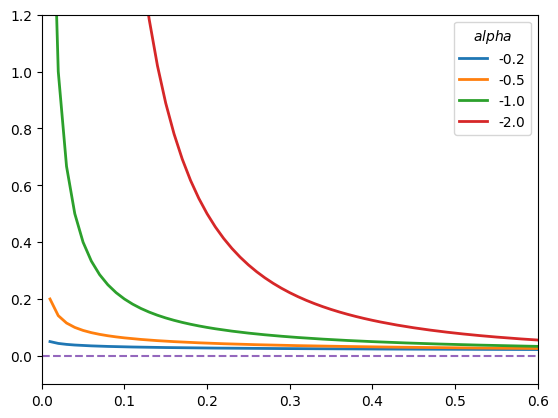

In [5]:
import numpy as np
import matplotlib.pyplot as plt

x_data = np.arange(0, 3, 0.01)
alpha = [0.2, 0.5, 1.0, 2.0]
y_data = [0.02 * x_data**-a for a in alpha]

for y, a in zip(y_data, alpha):
    plt.plot(x_data, y, label=f"-{a}", lw=2)

plt.plot(x_data, x_data * 0, "--")
plt.xlim(0, 0.6)
plt.ylim(-0.1, 1.2)
plt.legend(title="$alpha$")